In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import pickle
from ethnicseer import EthnicClassifier

tqdm.pandas(desc="Processing")

In [3]:
def calculate_stats(results_test, results_pred, name, display_labels):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    if len(display_labels) > 2:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, average='weighted')
        recall = recall_score(results_test, results_pred, average='weighted')
        f1 = f1_score(results_test, results_pred, average='weighted')
    else:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, pos_label='ind')
        recall = recall_score(results_test, results_pred, pos_label='ind')
        f1 = f1_score(results_test, results_pred, pos_label='ind')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)


In [4]:
def visualize_embeddings(X, y, names=None, n_samples=1000, method='tsne'):
    
    if len(X) > n_samples:
        idx = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[idx]
        y_sample = y[idx]
        if names is not None:
            names_sample = [names[i] for i in idx]
        else:
            names_sample = None
    else:
        X_sample = X
        y_sample = y
    
    if method == 'tsne':
        # Use t-SNE for dimensionality reduction
        reducer = TSNE(n_components=3, random_state=42)
    else:
        # Use PCA as fallback
        reducer = PCA(n_components=3)
    
    embeddings = reducer.fit_transform(X_sample)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_classes = np.unique(y_sample)
    colors = sns.color_palette("husl", len(unique_classes))
    
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        ax.scatter(embeddings[mask, 0], embeddings[mask, 1], embeddings[mask, 2],
                   color=colors[i], label=cls, alpha=0.6)
    
    ax.set_title('3D Visualization of Name Embeddings')
    ax.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        plt.scatter(embeddings[mask, 0], embeddings[mask, 1],
                    color=colors[i], label=cls, alpha=0.6)
    
    plt.title('2D Visualization of Name Embeddings')
    plt.legend()
    plt.show()
    
    
    if names_sample is not None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
        
        # First plot the points
        for i, cls in enumerate(unique_classes):
            mask = (y_sample == cls)
            ax.scatter(embeddings[mask, 0], embeddings[mask, 1],
                        color=colors[i], label=cls, alpha=0.6)
        
        # Then add text labels
        for i, (x, y) in enumerate(zip(embeddings[:, 0], embeddings[:, 1])):
            ax.text(x, y, names_sample[i], fontsize=8, alpha=0.7,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))
        
        plt.title('2D Visualization with Name Labels')
        plt.legend()
        plt.show()

In [5]:
def preprocess_name(name):
    parts = name.strip().split()
    first_name = parts[0].lower() if len(parts) > 0 else ""
    last_name = parts[-1].lower() if len(parts) > 1 else ""
    
    f4_first = first_name[:4] if len(first_name) >= 4 else first_name
    l4_first = first_name[-4:] if len(first_name) >= 4 else first_name
    f4_last = last_name[:4] if len(last_name) >= 4 else last_name
    l4_last = last_name[-4:] if len(last_name) >= 4 else last_name
    
    n_sub_names = len(parts)
    has_dash = any('-' in part for part in parts)
    
    return {
        'first_name': first_name,
        'last_name': last_name,
        'f4_first': f4_first,
        'l4_first': l4_first,
        'f4_last': f4_last,
        'l4_last': l4_last,
        'n_sub_names': min(n_sub_names, 4),
        'has_dash': int(has_dash)
    }


In [6]:
def build_name_stats(df, name_col='name', ethnicity_col='ethnic'):
    first_name_stats = defaultdict(lambda: defaultdict(int))
    last_name_stats = defaultdict(lambda: defaultdict(int))
    f4_first_stats = defaultdict(lambda: defaultdict(int))
    l4_first_stats = defaultdict(lambda: defaultdict(int))
    f4_last_stats = defaultdict(lambda: defaultdict(int))
    l4_last_stats = defaultdict(lambda: defaultdict(int))
    
    for _, row in df.iterrows():
        name_info = preprocess_name(row[name_col])
        ethnicity = row[ethnicity_col]
        
        first_name_stats[name_info['first_name']][ethnicity] += 1
        last_name_stats[name_info['last_name']][ethnicity] += 1
        f4_first_stats[name_info['f4_first']][ethnicity] += 1
        l4_first_stats[name_info['l4_first']][ethnicity] += 1
        f4_last_stats[name_info['f4_last']][ethnicity] += 1
        l4_last_stats[name_info['l4_last']][ethnicity] += 1
    
    return {
        'first_name_stats': first_name_stats,
        'last_name_stats': last_name_stats,
        'f4_first_stats': f4_first_stats,
        'l4_first_stats': l4_first_stats,
        'f4_last_stats': f4_last_stats,
        'l4_last_stats': l4_last_stats
    }


In [7]:
def create_features(name, stats, cats=['ind', 'not']):
    name_info = preprocess_name(name)
    features = {}
    
    for eth in cats:
        fn_counts = stats['first_name_stats'][name_info['first_name']]
        total_fn = sum(fn_counts.values())
        features[f'probability_{eth}_first_name'] = fn_counts.get(eth, 0) / (total_fn + 1)
        
        ln_counts = stats['last_name_stats'][name_info['last_name']]
        total_ln = sum(ln_counts.values())
        features[f'probability_{eth}_last_name'] = ln_counts.get(eth, 0) / (total_ln + 1)
        
        f4f_counts = stats['f4_first_stats'][name_info['f4_first']]
        total_f4f = sum(f4f_counts.values())
        features[f'probability_{eth}_first_name_f4'] = f4f_counts.get(eth, 0) / (total_f4f + 1)
        
        l4f_counts = stats['l4_first_stats'][name_info['l4_first']]
        total_l4f = sum(l4f_counts.values())
        features[f'probability_{eth}_first_name_l4'] = l4f_counts.get(eth, 0) / (total_l4f + 1)
        
        f4l_counts = stats['f4_last_stats'][name_info['f4_last']]
        total_f4l = sum(f4l_counts.values())
        features[f'probability_{eth}_last_name_f4'] = f4l_counts.get(eth, 0) / (total_f4l + 1)
        
        l4l_counts = stats['l4_last_stats'][name_info['l4_last']]
        total_l4l = sum(l4l_counts.values())
        features[f'probability_{eth}_last_name_l4'] = l4l_counts.get(eth, 0) / (total_l4l + 1)
        
        features[f'best_evidence_{eth}'] = max(
            features[f'probability_{eth}_first_name'],
            features[f'probability_{eth}_last_name']
        )
    
    features['dash_indicator'] = name_info['has_dash']
    features['n_sub_names'] = name_info['n_sub_names']
    
    return features


In [8]:
def is_indistinguishable(name, stats, threshold=0.15):
    
    name_info = preprocess_name(name)
    features = create_features(name, stats)
    
    cats = sorted(stats['first_name_stats'][name_info['first_name']].keys())
    psi = {cat: features[f'probability_{cat}_first_name'] for cat in cats}
    phi = {cat: features[f'probability_{cat}_last_name'] for cat in cats}
    
    indistinguishable_pairs = []
    
    for i, r1 in enumerate(cats):
        for r2 in cats[i+1:]:
            
            condition1 = (abs(psi[r1] - psi[r2]) <= threshold and 
                         abs(phi[r1] - phi[r2]) <= threshold)
            
            max_psi = max(psi.values())
            max_phi = max(phi.values())
            condition2 = (max_psi - min(psi[r1], psi[r2]) <= threshold and 
                         max_phi - min(phi[r1], phi[r2]) <= threshold)
            
            if condition1 and condition2:
                indistinguishable_pairs.append(f"{r1}-{r2}")
    
    return indistinguishable_pairs if indistinguishable_pairs else None


In [9]:
def handle_indistinguishables(df, stats, name_col='name'):
    
    df['indistinguishable'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        name = row[name_col]
        indistinguishable = is_indistinguishable(name, stats)
        
        if indistinguishable:
            df.at[idx, 'indistinguishable'] = ','.join(indistinguishable)
    
    return df


In [10]:
def process_data(df, name_col='name', ethnicity_col='ethnic', train_size=100000):
    
    stats = build_name_stats(df, name_col, ethnicity_col)
    
    class_counts = df[ethnicity_col].value_counts()
    class_weights = {class_counts.index[i]: sum(class_counts)/count for i, count in enumerate(class_counts)}
    
    X, y = [], []
    for _, row in tqdm(df.iterrows()):
        features = create_features(row[name_col], stats)
        X.append(list(features.values()))
        y.append(row[ethnicity_col])
    
    X, y = np.array(X), np.array(y)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    visualize_embeddings(X, y, list(df[name_col]))
    
    return X_train, X_test, y_train, y_test, class_weights
    

In [11]:
def name_classifier(df, X_train, X_test, y_train, y_test, class_weights, name_col='name', ethnicity_col='ethnic'):
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight=class_weights
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    cats = sorted(df[ethnicity_col].unique())
    
    calculate_stats(y_test, y_pred, "Name Classifier", cats)
    
    return model


In [11]:
df = pd.read_csv("./data/wiki_name_race.csv")
df["ethnic"] = df["race"].apply(lambda x: x.split(",")[-1])
df["name"] = df['name_first'].str.cat(df[['name_middle', 'name_last', 'name_suffix']], sep=' ', na_rep='')
df

,name_last,name_suffix,name_first,name_middle,race,ethnic,name
0,heynis,NaN,aafje,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,aafje heynis
1,noordewier-reddingius,NaN,aaltje,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,aaltje noordewier-reddingius
2,de quant,NaN,abbie,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abbie de quant
3,NaN,NaN,abbo of provence,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abbo of provence
4,ahanfouf,NaN,abdelaziz,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abdelaziz ahanfouf
...,...,...,...,...,...,...,...
148270,NaN,NaN,zoe,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoe
148271,karbonopsina,NaN,zoe,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoe karbonopsina
148272,mirkoviÄ,NaN,zoran,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoran mirkoviÄ
148273,NaN,NaN,zotto,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zotto


In [12]:
df = df[["name", "ethnic"]]
df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")
df = df.dropna()
df

C:\Users\karnav\AppData\Local\Temp\ipykernel_17992\784486912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")


,name,ethnic
0,aafje heynis,not
1,aaltje noordewier-reddingius,not
2,abbie de quant,not
3,abbo of provence,not
4,abdelaziz ahanfouf,not
...,...,...
148270,zoe,not
148271,zoe karbonopsina,not
148272,zoran mirkoviÄ,not
148273,zotto,not


In [13]:
df["ethnic"].value_counts()

ethnic
not    139212
ind      9063
Name: count, dtype: int64

In [12]:
# https://github.com/philipperemy/name-dataset
df_indian = pd.read_csv("./data/IN.csv")
df_indian.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_indian['firstname'] = df_indian['firstname'].apply(lambda x: x.split(" ")[0] if " " in str(x) else str(x))
df_indian['lastname'] = df_indian['lastname'].apply(lambda x: x.split(" ")[-1] if " " in str(x) else str(x))
df_indian['name'] = df_indian['firstname'].apply(lambda x: x.lower()) + ' ' + df_indian['lastname'].apply(lambda x: x.lower())
df_indian["ethnic"] = df_indian["ethnicity"].apply(lambda x: "ind")
df_indian

,firstname,lastname,gender,ethnicity,name,ethnic
0,Kapil,Kumar,M,IN,kapil kumar,ind
1,Mitali,Aggarwal,F,IN,mitali aggarwal,ind
2,Vikas,Jangra,NaN,IN,vikas jangra,ind
3,Ravi,Lungay,M,IN,ravi lungay,ind
4,Jagat,Yadav,M,IN,jagat yadav,ind
...,...,...,...,...,...,...
6161585,Vikas,Chakchanpur,M,IN,vikas chakchanpur,ind
6161586,Dipu,Gupta,M,IN,dipu gupta,ind
6161587,Riya,Naharwal,F,IN,riya naharwal,ind
6161588,Jashandeep,Hanjra,M,IN,jashandeep hanjra,ind


In [15]:
df_us = pd.read_csv("./data/US.csv")
df_us.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_us['name'] = df_us['firstname'].apply(lambda x: str(x).lower()) + ' ' + df_us['lastname'].apply(lambda x: str(x).lower())
df_us["ethnic"] = df_us["ethnicity"].apply(lambda x: "not")
df_us

,firstname,lastname,gender,ethnicity,name,ethnic
0,Brandon,Sylvester,M,US,brandon sylvester,not
1,Chris,Toussaint,M,US,chris toussaint,not
2,Willie,Gotti,M,US,willie gotti,not
3,Cristobal,Corona,M,US,cristobal corona,not
4,Wilmer,Diaz,M,US,wilmer diaz,not
...,...,...,...,...,...,...
32308967,Albert,Hall,M,US,albert hall,not
32308968,Dede,Love,M,US,dede love,not
32308969,Kylie,Smith,F,US,kylie smith,not
32308970,Koy,Smith,M,US,koy smith,not


In [16]:
df_combined = pd.concat([df_indian[["name", "ethnic"]], df_us[["name", "ethnic"]]], ignore_index=True)
df_combined = df_combined.sample(10000000, random_state=42)
df_combined

,name,ethnic
22816402,belkis perez,not
21783462,brian julich,not
3266115,sajajak alam,ind
34568050,sergio sergio,not
1979837,anilbhai anilbhai,ind
...,...,...
28079368,tasha oates,not
25500313,marie meyer,not
34664851,jeremy young,not
28132422,jasmine hill,not


In [25]:
df_indian["lastname"].value_counts()[3900:3920]

lastname
Nandha      127
Utekar      127
Zehra       127
Garad       127
Nikita      127
मंडल        127
Stalin      127
Wakode      127
Vini        127
Sathwara    127
Raha        127
Pamei       127
Mundo       127
Batt        127
Preethi     127
Dua         127
Ragul       127
Bob         127
Mitu        127
Sujeet      127
Name: count, dtype: int64

In [26]:
df_indian[df_indian["lastname"] == "Reddy"]

,firstname,lastname,gender,ethnicity,name,ethnic
5775,Kusikrm,Reddy,M,IN,kusikrm reddy,ind
20190,Kalia,Reddy,M,IN,kalia reddy,ind
28948,Govardhan,Reddy,M,IN,govardhan reddy,ind
42563,Kv,Reddy,M,IN,kv reddy,ind
50784,Munukuri,Reddy,M,IN,munukuri reddy,ind
...,...,...,...,...,...,...
6130649,Bhargav,Reddy,M,IN,bhargav reddy,ind
6135174,Charan,Reddy,M,IN,charan reddy,ind
6135689,Tharun,Reddy,M,IN,tharun reddy,ind
6139829,Ram,Reddy,M,IN,ram reddy,ind


In [23]:
df_indian["lastname"].to_list()[:1900]

['Kumar',
 'Aggarwal',
 'Jangra',
 'Lungay',
 'Yadav',
 'Kumari',
 'Kumar',
 'Singham',
 'Hanjra',
 'Rathor',
 'Ahamed',
 'Sahota',
 'Antil',
 'Dk',
 'Râjã',
 'Kumar',
 'Saini',
 'Chaudhary',
 'Khatri',
 'Sharma',
 'Narender',
 'Virk',
 'Chopda',
 'Bilawt',
 'Päyäl',
 'Khan',
 'Singh',
 'Kumar',
 'Yadav',
 'Kumar',
 'Rohit',
 'Rana',
 'Ohlan',
 'Chechi',
 'Mangal',
 'Singh',
 'Saini',
 'Moun',
 'Khana',
 'Singh',
 'Rana',
 'Goel',
 'Moun',
 'Manish',
 'Sharma',
 'Singh',
 'Goel',
 'Siwach',
 'Kumar',
 'ममीत',
 'Saini',
 'Naresh',
 'Jagwinder',
 'Khan',
 'Antal',
 'Narwal',
 'Sharma',
 'Lamba',
 'Kundu',
 'Singh',
 'Kaushik',
 'Avni',
 'Chunari',
 'Gujjar',
 'Jannat',
 'Sharma',
 'Sharma',
 'Bhardwaj',
 'Thàkür',
 'Yadav',
 'Sharma',
 'Kumar',
 'Chauhan',
 'Kumar',
 'Thakur',
 'Khokhar',
 'Neelam',
 'Khan',
 'Kadiyan',
 'Sunder',
 'Gupta',
 'Roy',
 'Kalia',
 'Foujdar',
 'Sharma',
 'Kumar',
 'Kumar',
 'Kumar',
 'Singh',
 'Bormon',
 'Khan',
 'Kumar',
 'Rawal',
 'Sultania',
 'Jakhouli',
 '

In [18]:
hindu_lastnames = ["Kumar", "Singh", "Sharma", "Yadav", "Patel", "Das", "Raj", "Gupta", 
                   "Thakur", "Rajput", "Kumari", "Patil", "Verma", "Chauhan", "Sahu", 
                   "Mishra", "Choudhary", "Rana", "Parmar", "Pal", "Mondal", "Pandey", 
                   "Ram", "Saini", "Shah", "Prajapati", "Jain", "Nayak", "Rathod", "Tiwari", 
                   "Soni", "Mandal", "Sarkar", "Malik", "Ahmad", "Bhai", "Meena", "Solanki",
                   "Chaudhary", "Jha", "Ghosh", "Jadhav", "Devi", "Pawar", "Raja", "Prasad",
                   "Kashyap", "Reddy", "Ray", "Rawat", "Saha", "Biswas", "Behera", "Thakor",
                   "Pradhan", "Sahoo", "Babu", "Joshi", "Rai", "Nath", "Naik", "Sinha", "Jaiswal",
                   "Shinde", "Lal", "Dey", "Dutta", "Rathore", "Paswan", "Gurjar", "Sah", "Barman",
                   "Agarwal", "Kushwaha", "Rao", "Pundit", "Chouhan", "Prakash", "Sen", "Shukla",
                   "Mehta", "Goswami", "Raji", "Gowda", "Pathan", "Gogoi", "Dubey", "Rani", "Maurya",
                   "Chavan", 'Gautam', 'Chaudhari', 'Kamble', 'Mali', 'Vishwakarma', 'Bhardwaj',
                   'Panchal', 'Kalita', 'Giri', 'Sagar', 'Vijay', 'More', 'Nishad', 'Patra', 
                   'Varma', 'Chakraborty', 'Pathak', 'Negi', 'Debnath', 'Ravi', 'Gaikwad', 
                   'Agrawal', 'Desai', 'Kumawat', 'Chand', 'Krishna', 'Mani', 'Vasava', 'Sing', 
                   'Sahani', 'Ranjan', "Kaur", 'Sonu', 'Majhi', 'Deka', 'Jena', 'Saikia', 'Rahul', 
                   'Jat', 'Suresh', 'Kadam', 'Bhagat', 'Borah', 'Ramesh', 'Srivastava', 'Bharti', 
                   'Vaghela', 'Anand', 'Mallick', "Goyal", "Bhat", "Bhatt", "Tripathi", "Khosla", "Reddy", "Parekh",
                   "Khan", "Ali", "Ansari", "Shaikh", "Sheikh"] 

In [19]:
df_us["ethnic"] = df_us["lastname"].apply(lambda x: "ind" if str(x).lower() in [y.lower() for y in hindu_lastnames] else "not")
df_us["ethnic"].value_counts()

ethnic
not    31887123
ind      421849
Name: count, dtype: int64

In [20]:
df_combined = pd.concat([df_indian[["name", "ethnic"]], df_us[["name", "ethnic"]].sample(15000000, random_state=42)], ignore_index=True)
df_combined = df_combined.sample(10000000, random_state=42)
df_combined["ethnic"].value_counts()

ethnic
not    6994611
ind    3005389
Name: count, dtype: int64

10000000it [05:28, 30433.37it/s]
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python312\Lib\subpro

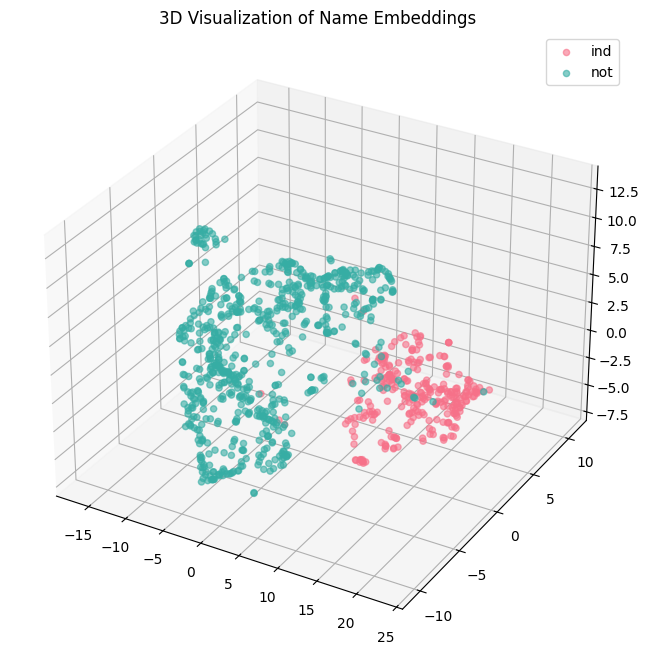

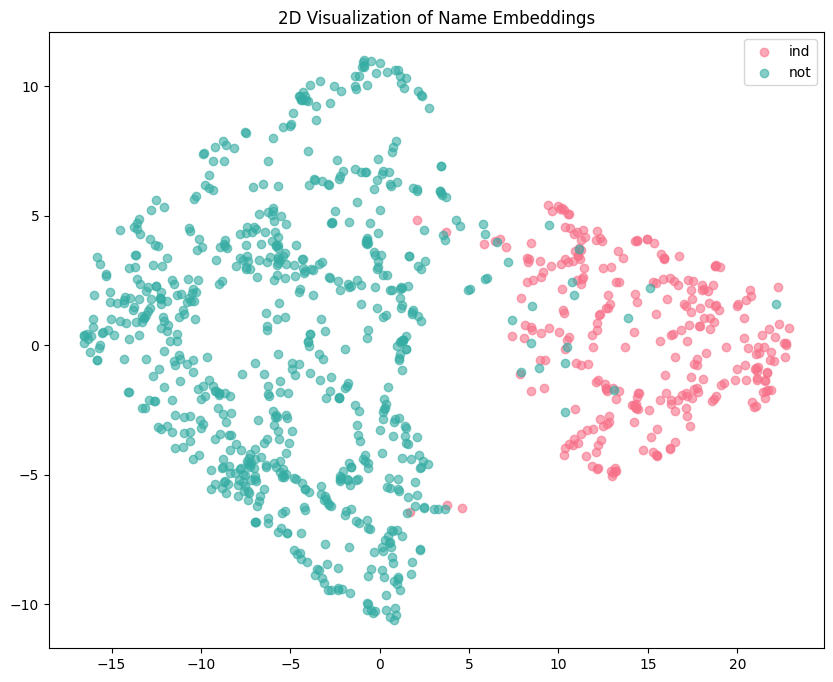

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2377 (\N{DEVANAGARI VOWEL SIGN CANDRA O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2

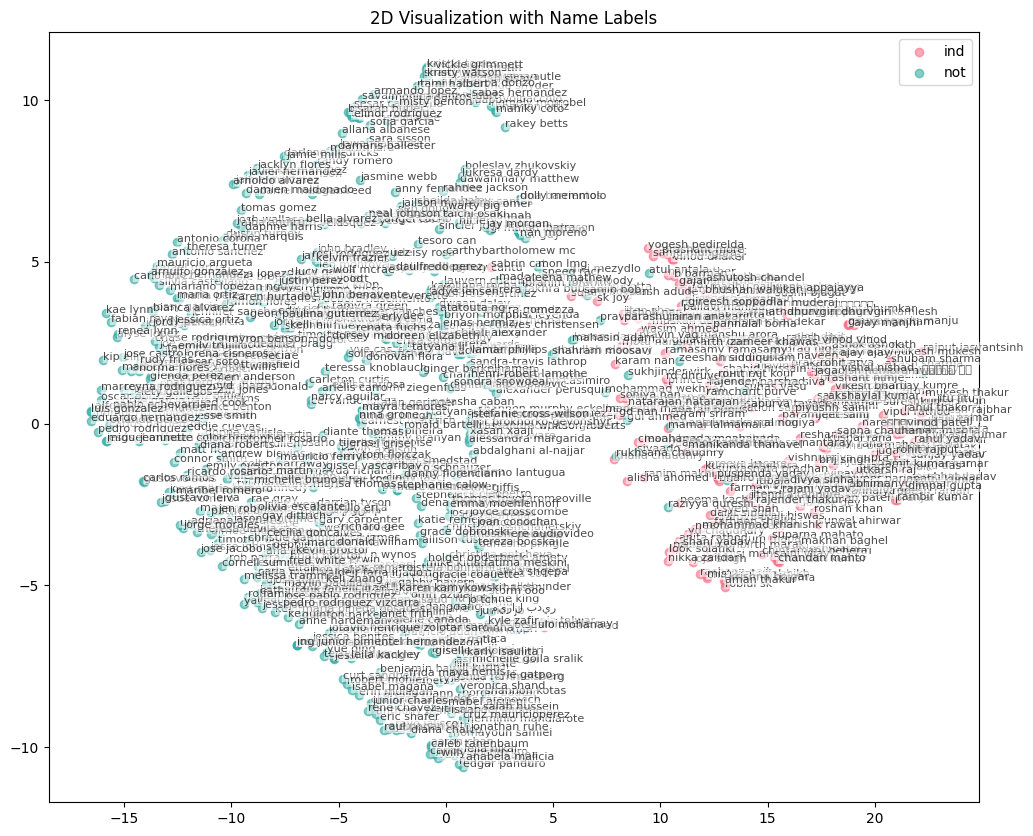

In [ ]:
X_train, X_test, y_train, y_test, weights = process_data(df_combined)

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


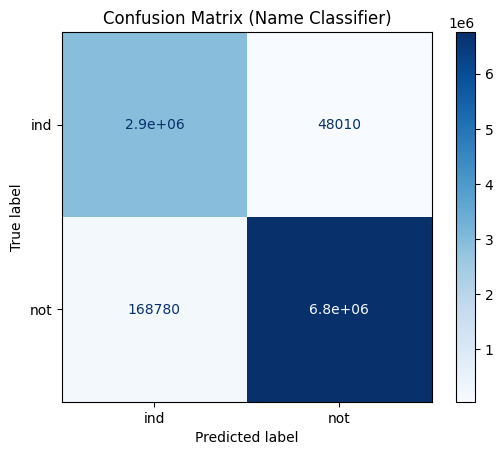


Name Classifier
Accuracy: 0.9781020202020202
Precision: 0.9454880703881496
Recall: 0.9838645333301069
F1: 0.9642946316281147


In [22]:
model = name_classifier(df_combined, X_train, X_test, y_train, y_test, weights)

In [23]:
y_probs = model.predict_proba(X_test)[:, 1]
y_probs.mean(), y_probs.std()

(0.6850610617158827, 0.4457993014000098)

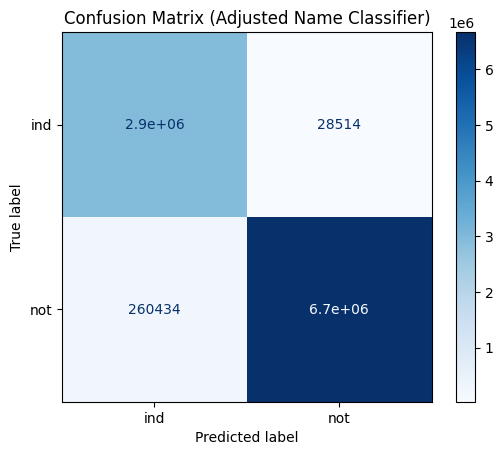


Adjusted Name Classifier
Accuracy: 0.9708133333333333
Precision: 0.918800955180175
Recall: 0.9904168569751024
F1: 0.9532657284272819


In [24]:
y_pred_adjusted = (y_probs <= 0.80).astype(int)
calculate_stats(y_test, np.where(y_pred_adjusted == 1, "ind", "not"), "Adjusted Name Classifier", sorted(df_combined["ethnic"].unique()))

In [25]:
sample = pd.read_csv("./top_donors_all.csv")
sample["firstname"] = sample["name"].apply(lambda x: x.split(",")[-1] if "," in x else str(x))
sample["lastname"] = sample["name"].apply(lambda x: x.split(",")[0] if "," in x else str(x))
sample["name_new"] = sample["firstname"].apply(lambda x: x.lower()) + ' ' + sample["lastname"].apply(lambda x: x.lower())
sample["ethnic"] = sample["actual"].apply(lambda x: "ind" if x == True else "not")
sample

,contrib_id,name,total_donated,donation_count,avg_donation,is_indian,actual,indian,firstname,lastname,name_new,ethnic
0,,"for america, amy",1255595260,27780,4.519781e+04,NaN,NaN,NaN,amy,for america,amy for america,not
1,U00000037041,"bloomberg, michael",1127712782,960,1.174701e+06,False,False,False,michael,bloomberg,michael bloomberg,not
2,U00000036521,"steyer, thomas f",379061294,779,4.865999e+05,False,False,False,thomas f,steyer,thomas f steyer,not
3,U00000046841,"mellon, timothy",45133555,23,1.962328e+06,False,False,False,timothy,mellon,timothy mellon,not
4,U0000000310A,"adelson, miriam o dr",44971550,134,3.356086e+05,False,False,False,miriam o dr,adelson,miriam o dr adelson,not
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,i3003933154,"title, lawrence",75828,146,5.193699e+02,False,False,False,lawrence,title,lawrence title,not
9996,q0001094848,"chaves, manny",75816,256,2.961562e+02,False,False,False,manny,chaves,manny chaves,not
9997,h10014870831,"adelman, david",75800,33,2.296970e+03,False,False,False,david,adelman,david adelman,not
9998,Y0000040866S,"brownstein, helen",75800,29,2.613793e+03,False,False,False,helen,brownstein,helen brownstein,not


In [26]:
sample["actual"].value_counts()

actual
False    9851
True      148
Name: count, dtype: int64

10000it [00:00, 38808.30it/s]


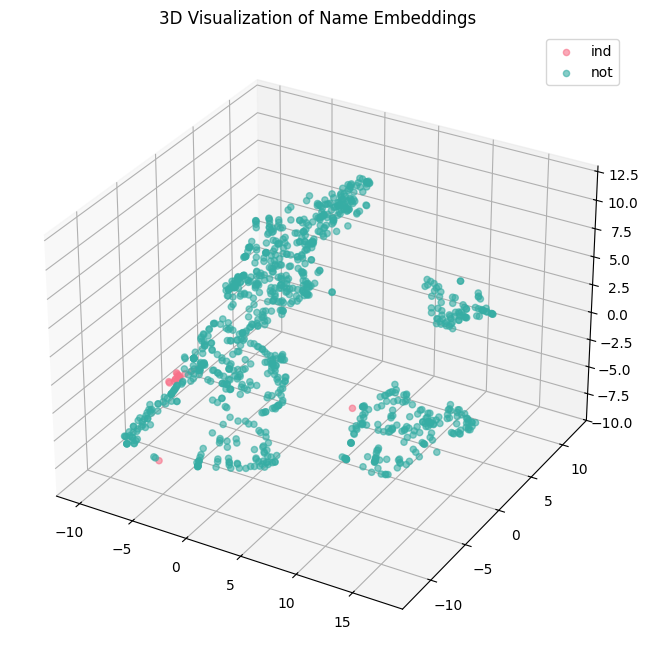

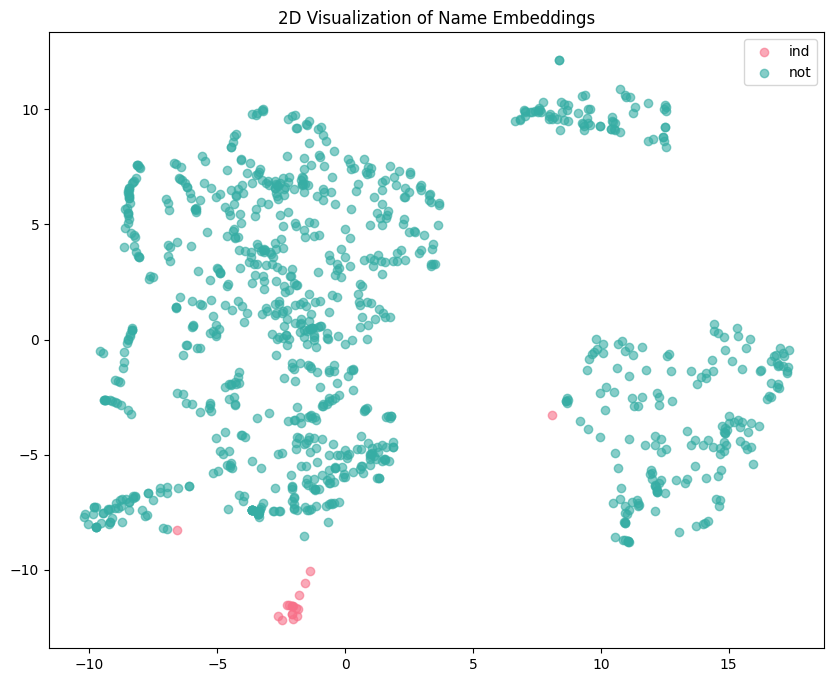

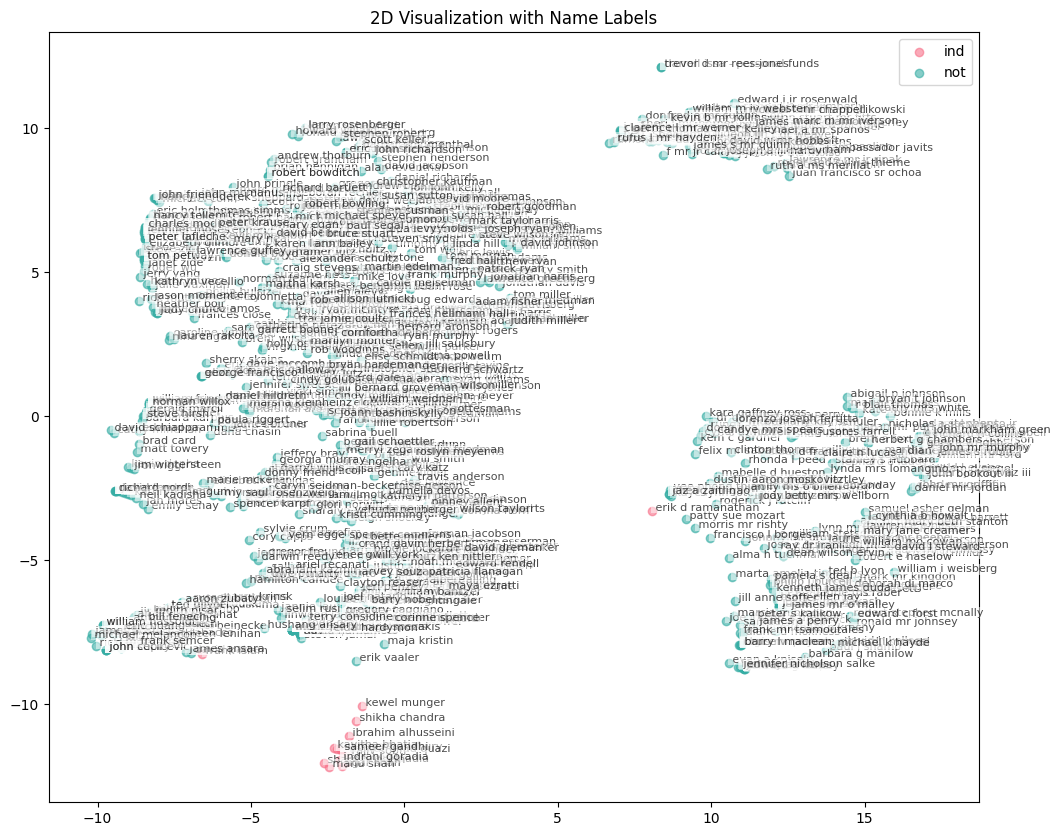

In [27]:
_, sample_test, _, y_sample_test, sample_weights = process_data(sample[["name_new", "ethnic"]], name_col="name_new", ethnicity_col="ethnic", train_size=1)

In [28]:
y_probs = model.predict_proba(sample_test)[:, 1]
y_probs.mean(), y_probs.std()

(0.961396963073138, 0.1091986682725914)

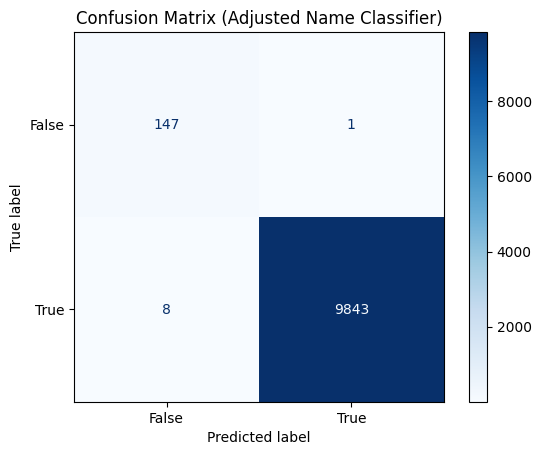


Adjusted Name Classifier
Accuracy: 0.9990999099909991
Precision: 0.9483870967741935
Recall: 0.9932432432432432
F1: 0.9702970297029703


In [34]:
y_pred_adjusted = (y_probs <= 0.80).astype(int)
calculate_stats(y_sample_test, np.where(y_pred_adjusted == 1, "ind", "not"), "Adjusted Name Classifier", sorted(sample["actual"].unique()[1:]))

In [35]:
with open('./models/logit_classifier.pkl', 'wb') as file:
    pickle.dump(model, file)

In [36]:
df_combined.to_csv('./data/USIN.csv', index=False)